In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the datasets
vis_main = fits.open('../data/vis_main_filtered.fits')[1].data

df = pd.DataFrame(np.array(vis_main).byteswap().newbyteorder())

In [2]:
import sys
import os

src_path = os.path.abspath("../src")
sys.path.insert(0, src_path)

import pandas as pd
from tqdm import tqdm
from bic_vs_components import compute_bic_vs_n_components
from gmm_analysis import fit_gmm_fixed_components, plot_gmm_with_contributions, extract_gmm_parameters


/Users/raunaqrai/miniforge3/envs/research_project_MW_GMM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Count how many entries have |z| < 2.5
num_z_below_2_5 = (df['Z'].abs() < 2.5).sum()
print(f"Number of stars with |z| < 2.5 kpc: {num_z_below_2_5}")

# Calculate the fraction of the total
fraction_z_below_2_5 = num_z_below_2_5 / len(df)
print(f"Fraction of stars with |z| < 2.5 kpc: {fraction_z_below_2_5:.2%}")

df = df[df['Z'].abs() < 2.5]


Number of stars with |z| < 2.5 kpc: 3304963
Fraction of stars with |z| < 2.5 kpc: 97.01%


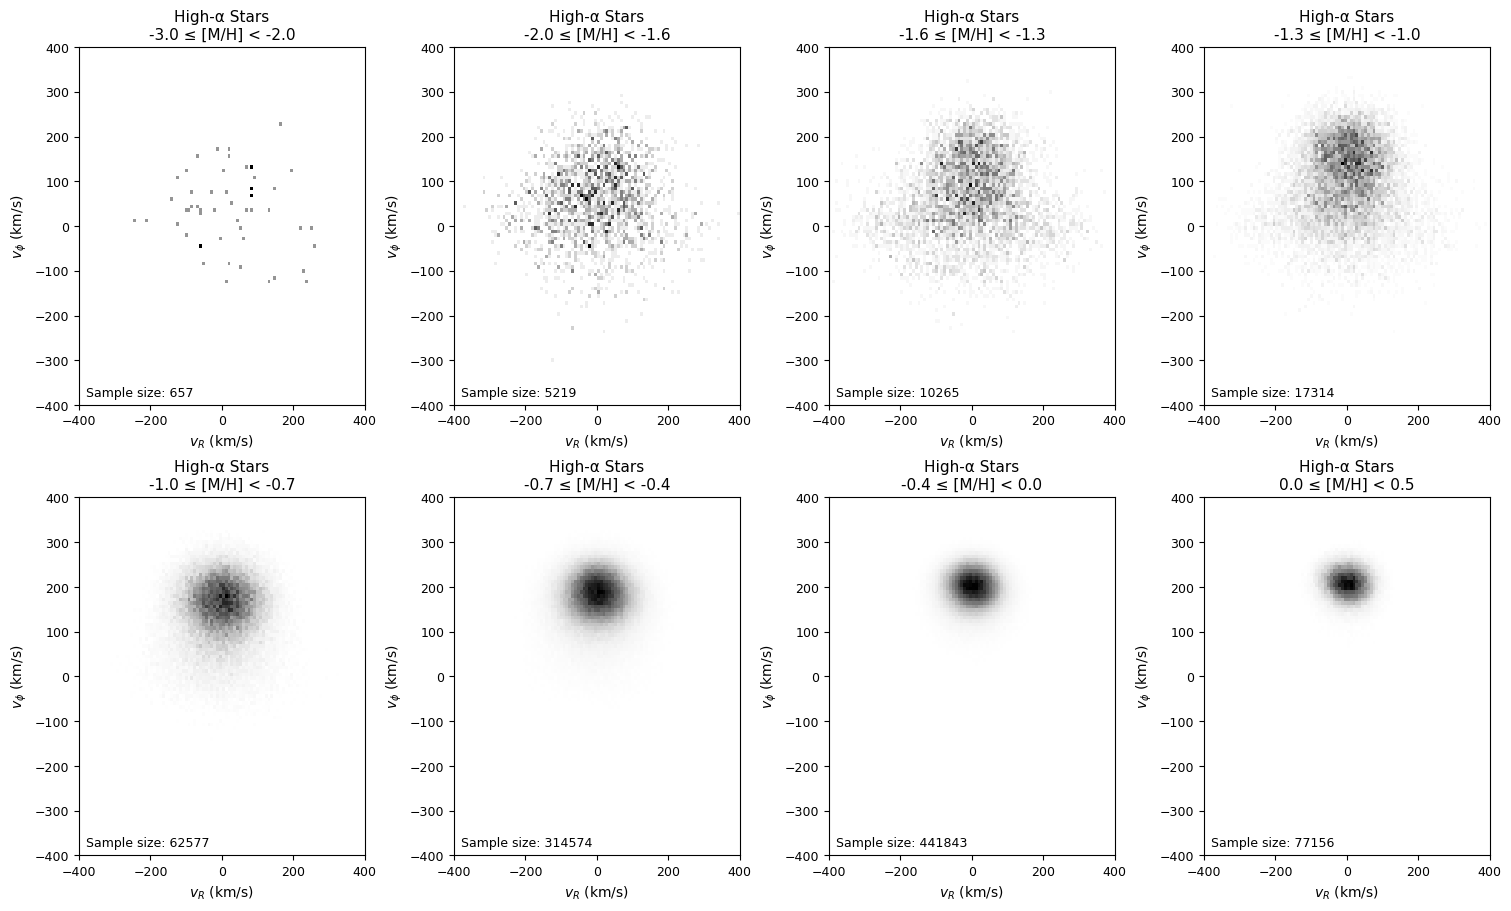

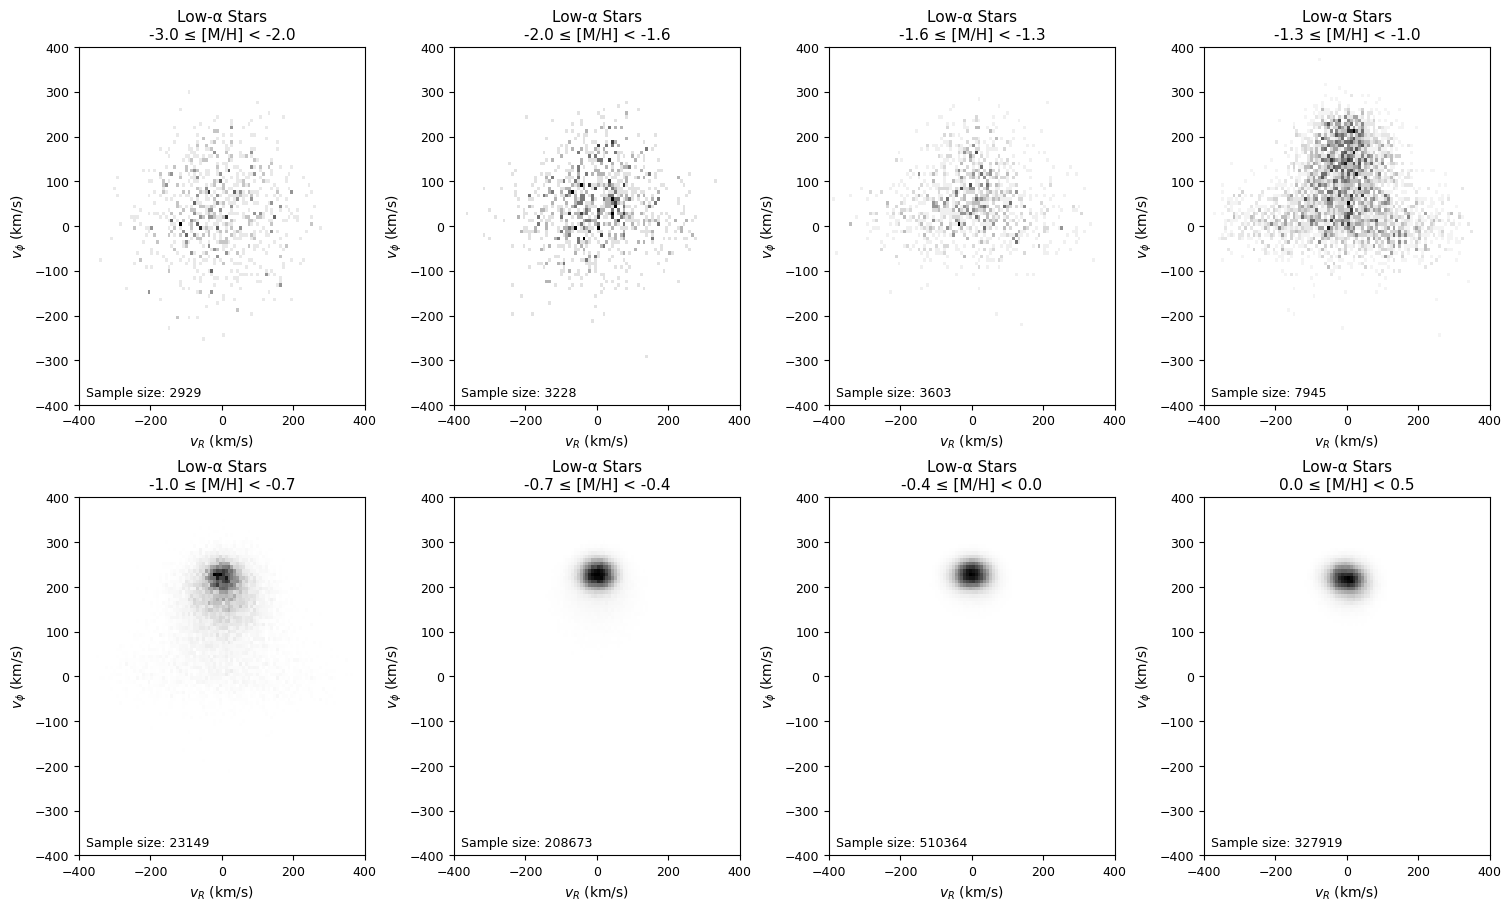

In [4]:
def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_vr_vphi_by_metallicity(df, title_prefix, save_prefix=None):
    # Define metallicity bins and labels
    metallicity_bins = [-3.0, -2.0, -1.6, -1.3, -1.0, -0.7, -0.4, 0.0, 0.5]
    bin_labels = [
        "-3.0 ≤ [M/H] < -2.0", "-2.0 ≤ [M/H] < -1.6", "-1.6 ≤ [M/H] < -1.3", "-1.3 ≤ [M/H] < -1.0",
        "-1.0 ≤ [M/H] < -0.7", "-0.7 ≤ [M/H] < -0.4", "-0.4 ≤ [M/H] < 0.0", "0.0 ≤ [M/H] < 0.5"
    ]

    bins = 100
    x_limits = (-400, 400)
    y_limits = (-400, 400)

    fig, axes = plt.subplots(2, 4, figsize=(15, 9), constrained_layout=True)

    for i, (low, high) in enumerate(zip(metallicity_bins[:-1], metallicity_bins[1:])):
        df_filtered = df[(df["mh_xgboost"] >= low) & (df["mh_xgboost"] < high)]
        df_filtered = df_filtered.dropna(subset=["v_R", "v_phi"])

        # Compute 2D histogram
        H, xedges, yedges = np.histogram2d(
            df_filtered["v_R"],
            df_filtered["v_phi"],
            bins=bins, range=[x_limits, y_limits], density=True
        )

        # Min-max normalization
        H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
        H_max = np.max(H) if np.max(H) > 0 else 1
        H_normalized = (H - H_min) / (H_max - H_min)
        H_normalized = np.clip(H_normalized, 0, 1)

        ax = axes[i // 4, i % 4]
        im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

        ax.set_title(f"{title_prefix}\n{bin_labels[i]}", fontsize=11)
        ax.set_xlabel(r"$v_R$ (km/s)", fontsize=10)
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.text(x_limits[0] + 20, y_limits[0] + 20, f"Sample size: {len(df_filtered)}", fontsize=9)

    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()


# Define high and low alpha populations
df_high, df_low = define_alpha_sequences(df)

# Plot for both populations
plot_vr_vphi_by_metallicity(df_high, title_prefix="High-α Stars",save_prefix='high_alpha')
plot_vr_vphi_by_metallicity(df_low, title_prefix="Low-α Stars",save_prefix='low_alpha')


In [5]:
def plot_bic_vs_n_components(BIC_values, save_prefix=None):
    """
    Plots BIC vs. Number of Components.

    Args:
    - BIC_values: Dictionary with BIC values for each component count.
    - save_prefix: Optional filename prefix for saving the figure.
    """
    num_components = sorted(BIC_values.keys())  # Sorted list of component numbers

    smallest_bic = [min(BIC_values[N]) for N in num_components]
    median_bic = [np.median(BIC_values[N]) for N in num_components]
    largest_bic = [max(BIC_values[N]) for N in num_components]
    q25_bic = [np.percentile(BIC_values[N], 25) for N in num_components]  # 25th percentile
    q75_bic = [np.percentile(BIC_values[N], 75) for N in num_components]  # 75th percentile

    min_bic = min(smallest_bic)
    min_index = smallest_bic.index(min_bic)
    best_n_components = num_components[min_index]


    plt.figure(figsize=(5, 6))
    plt.plot(num_components, smallest_bic, 'k-', label='Smallest BIC')
    plt.plot(num_components, q25_bic, 'g-.', label='25th Percentile BIC')
    plt.plot(num_components, median_bic, 'b--', label='Median BIC')
    plt.plot(num_components, q75_bic, '-.', label='75th Percentile BIC')
    plt.plot(num_components, largest_bic, 'r:', label='Largest BIC')
    plt.plot(best_n_components, min_bic, 'ro', markersize=8, label='Minimum BIC')

    plt.xlabel("Number of GMM Components",fontsize=14)
    plt.ylabel("{BIC Value}",fontsize=14)
    plt.title(f"{save_prefix}")
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()

In [6]:
df_vmp_high = df_high[(df_high['mh_xgboost'] >= -3.0) & (df_high['mh_xgboost'] < -2.0)]
df_imp_high = df_high[(df_high['mh_xgboost'] >= -2.0) & (df_high['mh_xgboost'] < -1.6)]
df_mp1_high = df_high[(df_high['mh_xgboost'] >= -1.6) & (df_high['mh_xgboost'] < -1.3)]
df_mp2_high = df_high[(df_high['mh_xgboost'] >= -1.3) & (df_high['mh_xgboost'] < -1.0)]

df_vmp_low = df_low[(df_low['mh_xgboost'] >= -3.0) & (df_low['mh_xgboost'] < -2.0)]
df_imp_low = df_low[(df_low['mh_xgboost'] >= -2.0) & (df_low['mh_xgboost'] < -1.6)]
df_mp1_low = df_low[(df_low['mh_xgboost'] >= -1.6) & (df_low['mh_xgboost'] < -1.3)]
df_mp2_low = df_low[(df_low['mh_xgboost'] >= -1.3) & (df_low['mh_xgboost'] < -1.0)]

In [7]:
bic_vmp_high_alpha = compute_bic_vs_n_components(df_vmp_high, max_components=8, n_init=50)

with open("../models/bic_vmp_high_alpha.json", "w") as f:
    json.dump(bic_vmp_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [09:04<00:00, 68.11s/it]


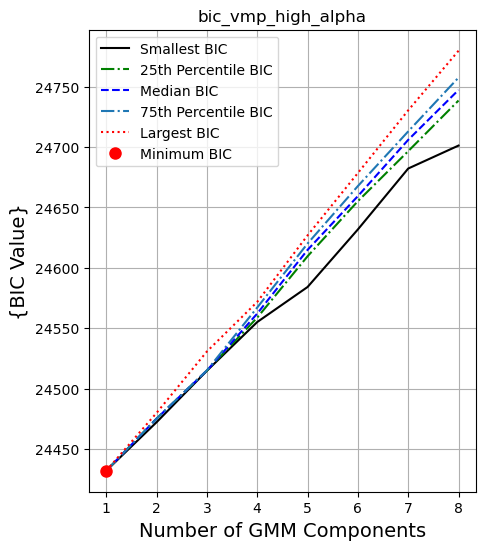

In [8]:
plot_bic_vs_n_components(bic_vmp_high_alpha, save_prefix='bic_vmp_high_alpha')

In [9]:
bic_imp_high_alpha = compute_bic_vs_n_components(df_imp_high, max_components=8, n_init=50)

with open("../models/bic_imp_high_alpha.json", "w") as f:
    json.dump(bic_imp_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [11:35<00:00, 86.98s/it]


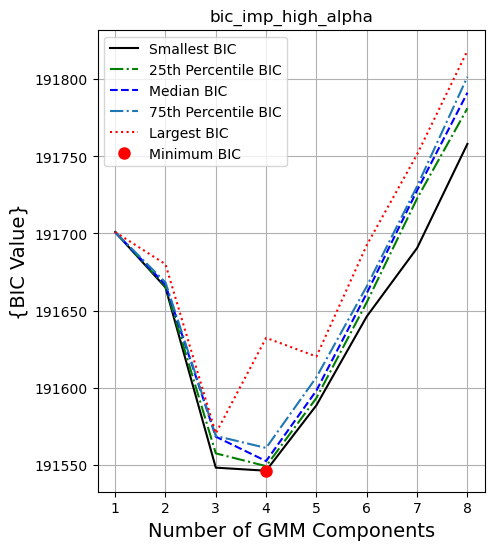

In [10]:
plot_bic_vs_n_components(bic_imp_high_alpha,save_prefix='bic_imp_high_alpha')

In [11]:
bic_mp1_high_alpha = compute_bic_vs_n_components(df_mp1_high, max_components=8, n_init=50)

with open("../models/bic_mp1_high_alpha.json", "w") as f:
    json.dump(bic_mp1_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [17:27<00:00, 130.97s/it]


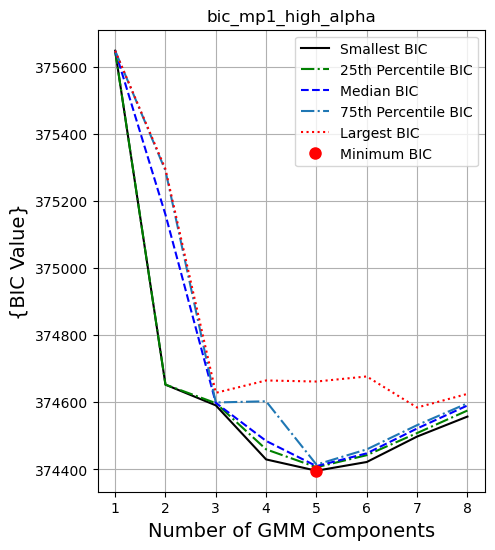

In [12]:
plot_bic_vs_n_components(bic_mp1_high_alpha,save_prefix='bic_mp1_high_alpha')

In [13]:
bic_mp2_high_alpha = compute_bic_vs_n_components(df_mp2_high, max_components=8, n_init=50)

with open("../models/bic_mp2_high_alpha.json", "w") as f:
    json.dump(bic_mp2_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [20:51<00:00, 156.49s/it]


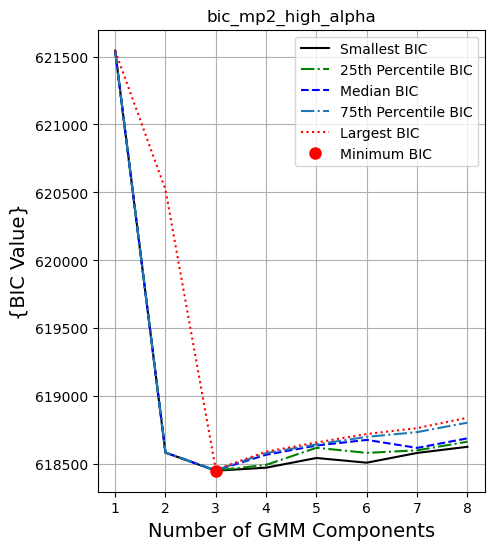

In [14]:
plot_bic_vs_n_components(bic_mp2_high_alpha,save_prefix='bic_mp2_high_alpha')

In [15]:
bic_vmp_low_alpha = compute_bic_vs_n_components(df_vmp_low, max_components=8, n_init=50)

with open("../models/bic_vmp_low_alpha.json", "w") as f:
    json.dump(bic_vmp_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [10:24<00:00, 78.12s/it] 


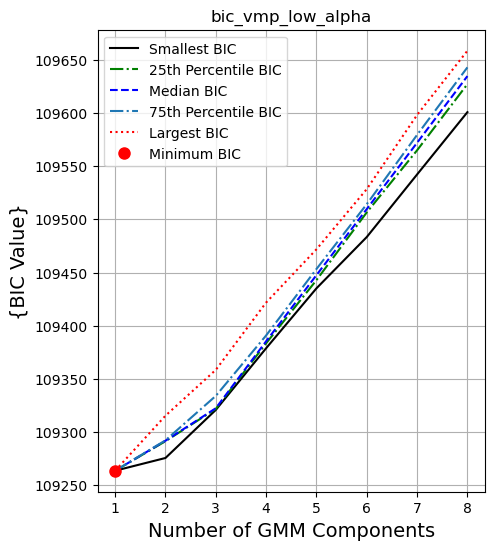

In [16]:
plot_bic_vs_n_components(bic_vmp_low_alpha,save_prefix='bic_vmp_low_alpha')

In [17]:
bic_imp_low_alpha = compute_bic_vs_n_components(df_imp_low, max_components=8, n_init=50)

with open("../models/bic_imp_low_alpha.json", "w") as f:
    json.dump(bic_imp_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [10:58<00:00, 82.27s/it]


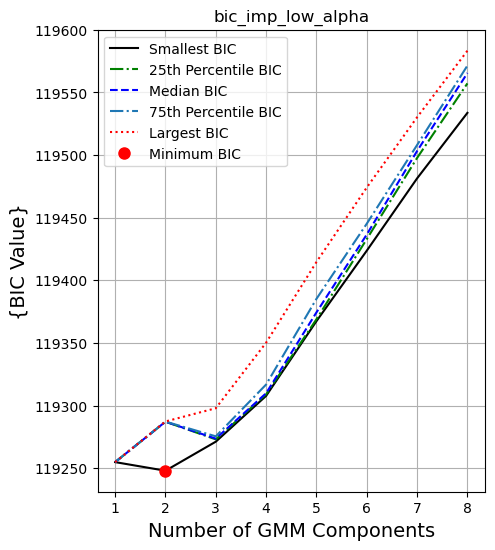

In [18]:
plot_bic_vs_n_components(bic_imp_low_alpha,save_prefix='bic_imp_low_alpha')

In [19]:
bic_mp1_low_alpha = compute_bic_vs_n_components(df_mp1_low, max_components=8, n_init=50)

with open("../models/bic_mp1_low_alpha.json", "w") as f:
    json.dump(bic_mp1_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [11:22<00:00, 85.26s/it] 


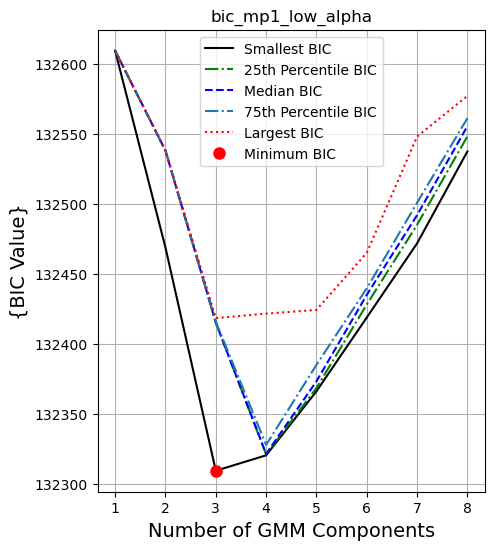

In [20]:
plot_bic_vs_n_components(bic_mp1_low_alpha,save_prefix='bic_mp1_low_alpha')

In [21]:
bic_mp2_low_alpha = compute_bic_vs_n_components(df_mp2_low, max_components=8, n_init=50)

with open("../models/bic_mp2_low_alpha.json", "w") as f:
    json.dump(bic_mp2_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [14:03<00:00, 105.47s/it]


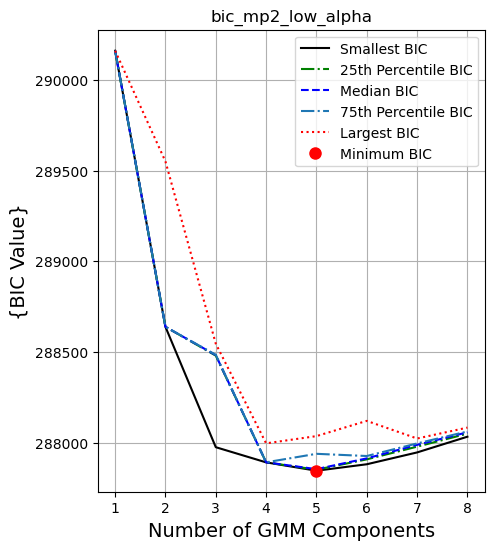

In [22]:
plot_bic_vs_n_components(bic_mp2_low_alpha,save_prefix='bic_mp2_low_alpha')

In [27]:
gmm_vmp_high = fit_gmm_fixed_components(df_vmp_high, n_components=1, n_init=100)

with open("../models/gmm_vmp_high.pkl", "wb") as f:
    pickle.dump(gmm_vmp_high, f)

Fitting GMM with 1 components: 100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


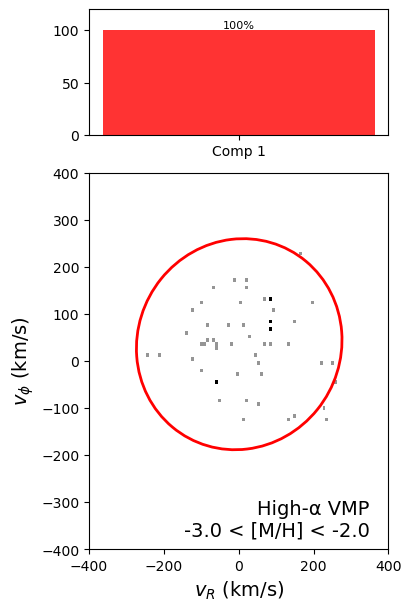


High-α VMP (-3.0 < [M/H] < -2.0) (657 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo    100.0      1.4      137.36     35.59       111.99      7.6      102.48  


In [8]:
colors = ["red"]

plot_gmm_with_contributions(
    df_bin=df_vmp_high,
    gmm=gmm_vmp_high,
    bin_label="High-α VMP",
    metallicity_range="-3.0 < [M/H] < -2.0",
    label="vmp_high_alpha_k1",
    component_colors=colors,
)

summary = extract_gmm_parameters(gmm_vmp_high, df_vmp_high, label="High-α VMP (-3.0 < [M/H] < -2.0)")
print(summary)

In [29]:
#imp high alpha component 4

gmm_imp_high = fit_gmm_fixed_components(df_imp_high, n_components=4, n_init=100)

with open("../models/gmm_imp_high.pkl", "wb") as f:
    pickle.dump(gmm_imp_high, f)

Fitting GMM with 4 components: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


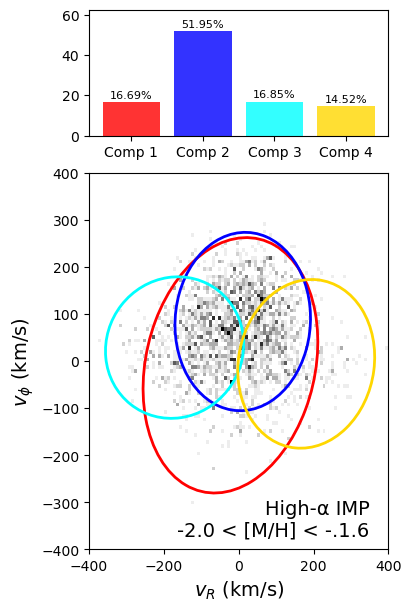


High-α IMP (-2.0 < [M/H] < -1.6) (5219 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     16.7      -22.06    116.74     -8.55       135.74     -2.64     125.40  
  Prograde halo     14.5      180.48     91.48     -5.47        89.66     -2.87      94.37  
         GS/E 1     16.8     -171.35     92.33     29.12        75.23      0.50      87.09  
         GS/E 2     51.9       10.84     90.56     84.51        94.79     -0.76      69.42  


In [9]:
colors = ["red", "blue", "aqua", "gold"]

plot_gmm_with_contributions(
    df_bin=df_imp_high,
    gmm=gmm_imp_high,
    bin_label="High-α IMP",
    metallicity_range="-2.0 < [M/H] < -.1.6",
    label="imp_high_alpha_k4",
    component_colors=colors,
)

summary = extract_gmm_parameters(gmm_imp_high, df_imp_high, label="High-α IMP (-2.0 < [M/H] < -1.6)")
print(summary)

In [31]:
#mp1 high alpha component 5

gmm_mp1_high = fit_gmm_fixed_components(df_mp1_high, n_components=5, n_init=100)

with open("../models/gmm_mp1_high.pkl", "wb") as f:
    pickle.dump(gmm_mp1_high, f)

Fitting GMM with 5 components: 100%|██████████| 100/100 [05:49<00:00,  3.49s/it]


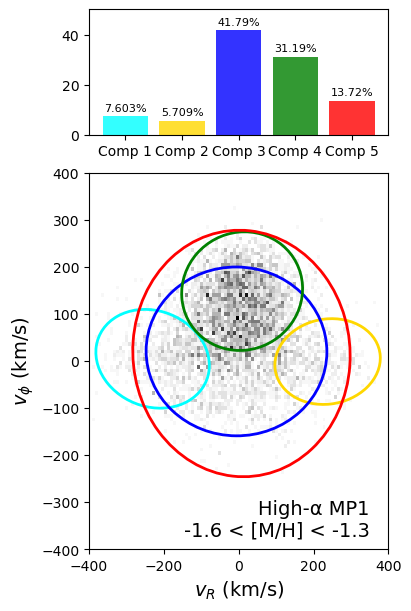


High-α MP1 (-1.6 < [M/H] < -1.3) (10265 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo      5.7      237.61     70.43      -1.23       45.51     -3.73      92.81  
  Prograde halo      7.6     -230.09     75.81       4.65       52.41      8.69      94.68  
         GS/E 1     13.7        7.44    145.24      15.90      130.80     -8.97     127.11  
         GS/E 2     41.8       -5.85    120.77      20.31       89.59     -1.29      72.85  
     Thick Disc     31.2        9.18     80.79     148.23       62.97      2.99      68.92  


In [10]:
colors = ["aqua", "gold", "blue", "green", "red"]

plot_gmm_with_contributions(
    df_bin=df_mp1_high,
    gmm=gmm_mp1_high,
    bin_label="High-α MP1",
    metallicity_range="-1.6 < [M/H] < -1.3",
    label="mp1_high_alpha_k5"
    , component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp1_high, df_mp1_high, label="High-α MP1 (-1.6 < [M/H] < -1.3)")
print(summary)

In [33]:
#mp2 high alpha component 3

gmm_mp2_high = fit_gmm_fixed_components(df_mp2_high, n_components=3, n_init=100)

with open("../models/gmm_mp2_high.pkl", "wb") as f:
    pickle.dump(gmm_mp2_high, f)


Fitting GMM with 3 components: 100%|██████████| 100/100 [05:16<00:00,  3.17s/it]


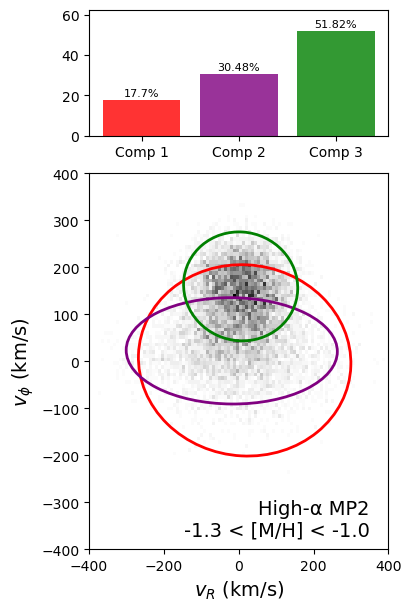


High-α MP2 (-1.3 < [M/H] < -1.0) (17314 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     17.7      15.91    141.96       2.13      101.75     -1.68     98.90   
  Prograde halo     30.5     -18.50    141.08      22.42       56.55     -2.40     77.98   
         GS/E 1     51.8       5.22     76.27     159.54       57.94     -0.83     67.18   


In [11]:
colors = ["red", "purple", "green"]

plot_gmm_with_contributions(
    df_bin=df_mp2_high,
    gmm=gmm_mp2_high,
    bin_label="High-α MP2",
    metallicity_range="-1.3 < [M/H] < -1.0",
    label="mp2_high_alpha_k6",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp2_high, df_mp2_high, label="High-α MP2 (-1.3 < [M/H] < -1.0)")
print(summary)

In [35]:
#vmp low alpha component 1

gmm_vmp_low = fit_gmm_fixed_components(df_vmp_low, n_components=1, n_init=100)

with open("../models/gmm_vmp_low.pkl", "wb") as f:
    pickle.dump(gmm_vmp_low, f)


Fitting GMM with 1 components: 100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


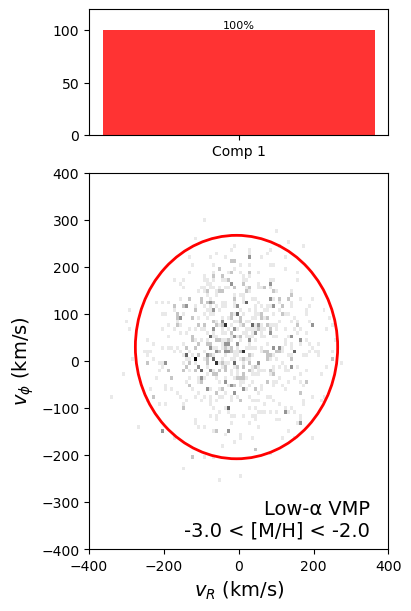


Low-α VMP (-3.0 < [M/H] < -2.0) (2929 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo    100.0     -5.82     135.18     29.55       118.56      1.34     107.1   


In [12]:
colors= ["red"]

plot_gmm_with_contributions(
    df_bin=df_vmp_low,
    gmm=gmm_vmp_low,
    bin_label="Low-α VMP",
    metallicity_range="-3.0 < [M/H] < -2.0",
    label="vmp_low_alpha_k1",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_vmp_low, df_vmp_low, label="Low-α VMP (-3.0 < [M/H] < -2.0)")
print(summary)

In [37]:
#imp low alpha component 2
gmm_imp_low = fit_gmm_fixed_components(df_imp_low, n_components=2, n_init=100)

with open("../models/gmm_imp_low.pkl", "wb") as f:
    pickle.dump(gmm_imp_low, f)

Fitting GMM with 2 components: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


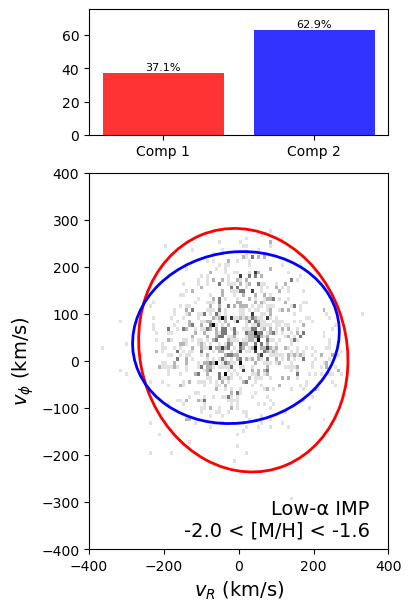


Low-α IMP (-2.0 < [M/H] < -1.6) (3228 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     37.1     12.33     139.85     22.87       129.23     -4.43     120.51  
  Prograde halo     62.9     -7.34     138.11     49.68        91.25      4.08      75.99  


In [13]:
colors = ["red", "blue"]

plot_gmm_with_contributions(
    df_bin=df_imp_low,
    gmm=gmm_imp_low,
    bin_label="Low-α IMP",
    metallicity_range="-2.0 < [M/H] < -1.6",
    label="imp_low_alpha_k2",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_imp_low, df_imp_low, label="Low-α IMP (-2.0 < [M/H] < -1.6)")
print(summary)

In [23]:
#mp1 low alpha component 3

gmm_mp1_low = fit_gmm_fixed_components(df_mp1_low, n_components=3, n_init=100)

with open("../models/gmm_mp1_low.pkl", "wb") as f:
    pickle.dump(gmm_mp1_low, f)


Fitting GMM with 3 components: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


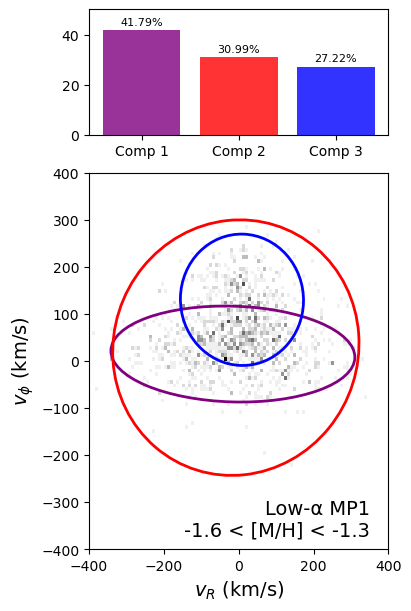


Low-α MP1 (-1.6 < [M/H] < -1.3) (3603 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     41.8     -15.50    162.97      14.71       50.94     -1.93      73.60  
  Prograde halo     31.0      -7.58    164.57      28.31      135.62     -4.92     121.66  
         GS/E 1     27.2       8.72     82.25     129.87       69.71      3.13      60.68  


In [14]:
colors = ["purple", "red", "blue"]

plot_gmm_with_contributions(
    df_bin=df_mp1_low,
    gmm=gmm_mp1_low,
    bin_label="Low-α MP1",
    metallicity_range="-1.6 < [M/H] < -1.3",
    label="mp1_low_alpha_k4",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp1_low, df_mp1_low, label="Low-α MP1 (-1.6 < [M/H] < -1.3)")
print(summary)

In [39]:
#mp2 low alpha component 5

gmm_mp2_low = fit_gmm_fixed_components(df_mp2_low, n_components=5, n_init=100)

with open("../models/gmm_mp2_low.pkl", "wb") as f:
    pickle.dump(gmm_mp2_low, f)


Fitting GMM with 5 components: 100%|██████████| 100/100 [04:09<00:00,  2.49s/it]


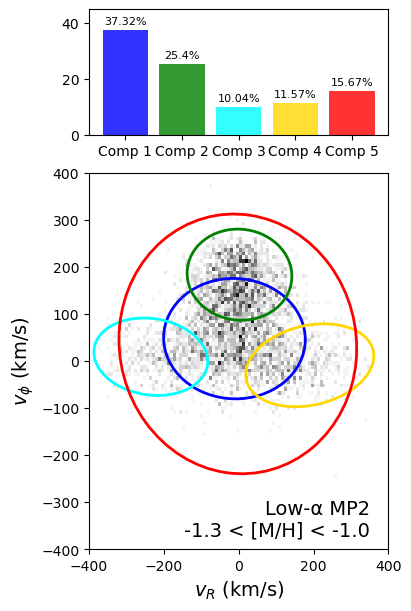


Low-α MP2 (-1.3 < [M/H] < -1.0) (7945 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     11.6      189.95     85.58      -9.15       43.99     -8.49      89.69  
  Prograde halo     10.0     -234.89     76.09       8.99       41.09     10.70      93.79  
         GS/E 1     15.7       -2.30    158.84      36.24      137.81      2.81     131.10  
         GS/E 2     37.3      -11.31     94.62      47.39       63.89     -1.18      63.12  
     Thick Disc     25.4        2.13     69.98     183.15       48.36      1.75      54.21  


In [15]:
colors = ["blue", "green", "aqua", "gold", "red"]

plot_gmm_with_contributions(
    df_bin=df_mp2_low,
    gmm=gmm_mp2_low,
    bin_label="Low-α MP2",
    metallicity_range="-1.3 < [M/H] < -1.0",
    label="mp2_low_alpha_k6",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp2_low, df_mp2_low, label="Low-α MP2 (-1.3 < [M/H] < -1.0)")
print(summary)

In [7]:
model_paths = {
    "gmm_imp_high": "../models/gmm_imp_high.pkl",
    "gmm_imp_low": "../models/gmm_imp_low.pkl",
    "gmm_mp1_high": "../models/gmm_mp1_high.pkl",
    "gmm_mp1_low": "../models/gmm_mp1_low.pkl",
    "gmm_mp2_high": "../models/gmm_mp2_high.pkl",
    "gmm_mp2_low": "../models/gmm_mp2_low.pkl",
    "gmm_vmp_high": "../models/gmm_vmp_high.pkl",
    "gmm_vmp_low": "../models/gmm_vmp_low.pkl"
}

for name, path in model_paths.items():
    with open(path, "rb") as f:
        globals()[name] = pickle.load(f)
